In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from pymatgen.io.cif import CifWriter
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.ext.matproj import MPRester
from pymatgen.electronic_structure.core import Spin
from scipy.interpolate import UnivariateSpline
import pandas as pd
from scipy.optimize import minimize
from scipy import integrate
from sympy import symbols, Eq, Integral, exp, init_printing

In [3]:
mp_key = "saKvn4nYOR6knw5q6WoAxtMKCsoAG1gq"
mp_id = "mp-561586"

In [4]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()
symmops = SpacegroupAnalyzer(conv_struc).get_space_group_operations()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Calcul des températures d'Einstein et de Debye

Le modèle d’Einstein est une approximation de la capacité thermique des solides basée sur l’hypothèse que tous les atomes d’un cristal oscillent indépendamment avec la même fréquence, appelée fréquence d’Einstein. Il suppose que ces oscillations suivent la statistique de Bose-Einstein. La capacité thermique est calculée en intégrant l’énergie moyenne d’un oscillateur quantique sur toutes les températures, ce qui donne l’expression : 


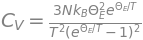

où k_B est la constante de Boltzmann et N le nombre d'atomes du système 


In [6]:
print("Le modèle d’Einstein est une approximation de la capacité thermique des solides basée sur l’hypothèse que tous les atomes d’un cristal oscillent indépendamment avec la même fréquence, appelée fréquence d’Einstein. Il suppose que ces oscillations suivent la statistique de Bose-Einstein. La capacité thermique est calculée en intégrant l’énergie moyenne d’un oscillateur quantique sur toutes les températures, ce qui donne l’expression : ")

init_printing()
N, k_B, Theta_E, T, C_V = symbols('N k_B Θ_E T C_V')
expr = Eq(C_V, 3 * N * k_B * (Theta_E / T)**2 * exp(Theta_E / T) / (exp(Theta_E / T) - 1)**2)
display(expr)
print("où k_B est la constante de Boltzmann et N le nombre d'atomes du système ")

In [54]:
# définition des constantes
R_const = 8.314
T_vals = np.arange(1, 1000, 5)
num_atoms = len(prim_struc)


In [55]:
# calcul des capacités thermiques normalisées
exp_cv = np.array([ph_dos.cv(T) for T in T_vals]) / (3 * num_atoms * R_const)

In [56]:
# modèle d'Einstein
def einstein_cv(T, T_e):
    return (T_e / T) ** 2 * np.exp(T_e / T) / (np.exp(T_e / T) - 1) ** 2

def einstein_error(T_e):
    return np.sum((exp_cv - einstein_cv(T_vals, T_e)) ** 2)

In [57]:
# optimisation de la température d'Einstein
T_e_init = 300
T_e_opt = minimize(einstein_error, T_e_init).x[0]
print(f"Température d'Einstein optimisée : {T_e_opt:.2f} K")

Température d'Einstein optimisée : 184.72 K


Le modèle de Debye est une amélioration du modèle d’Einstein qui prend en compte l’interaction collective des vibrations des atomes dans un solide. Il suppose que les modes de vibration suivent une distribution continue jusqu'à une fréquence maximale, appelée fréquence de Debye. La capacité thermique C_V est obtenue par intégration de la densité d’états phononique et s’exprime comme :


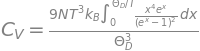

où Θ_D est la température de Debye, k_B la constante de Boltzmann et N e nombre d’atomes du solide. Ce modèle décrit mieux la variation de C_V  à basse température que celui d’Einstein.


In [7]:
print("Le modèle de Debye est une amélioration du modèle d’Einstein qui prend en compte l’interaction collective des vibrations des atomes dans un solide. Il suppose que les modes de vibration suivent une distribution continue jusqu'à une fréquence maximale, appelée fréquence de Debye. La capacité thermique C_V est obtenue par intégration de la densité d’états phononique et s’exprime comme :")
init_printing()

N, k_B, T, Theta_D, x, C_V = symbols('N k_B T Θ_D x C_V')

debye_integral = Integral((x**4 * exp(x)) / (exp(x) - 1)**2, (x, 0, Theta_D / T))
expr_debye = Eq(C_V, 9 * N * k_B * (T / Theta_D)**3 * debye_integral)

display(expr_debye)
print("où Θ_D est la température de Debye, k_B la constante de Boltzmann et N e nombre d’atomes du solide. Ce modèle décrit mieux la variation de C_V  à basse température que celui d’Einstein.")

In [59]:
# Modèle de Debye
def debye_integrand(x):
    return (x**4 * np.exp(x)) / (np.exp(x) - 1) ** 2

def debye_cv(T, T_d):
    return 3 * (T / T_d) ** 3 * integrate.quad(debye_integrand, 0, T_d / T)[0]

def debye_error(T_d):
    return np.sum([(debye_cv(T, T_d) - exp_cv[i]) ** 2 for i, T in enumerate(T_vals)])


In [60]:
# Optimisation de la température de Debye
T_d_init = 300
T_d_opt = minimize(debye_error, T_d_init).x[0]
print(f"Température de Debye optimisée : {T_d_opt:.2f} K")


Température de Debye optimisée : 250.37 K


représentation des 3 courbes de chaleurs spécifiques 

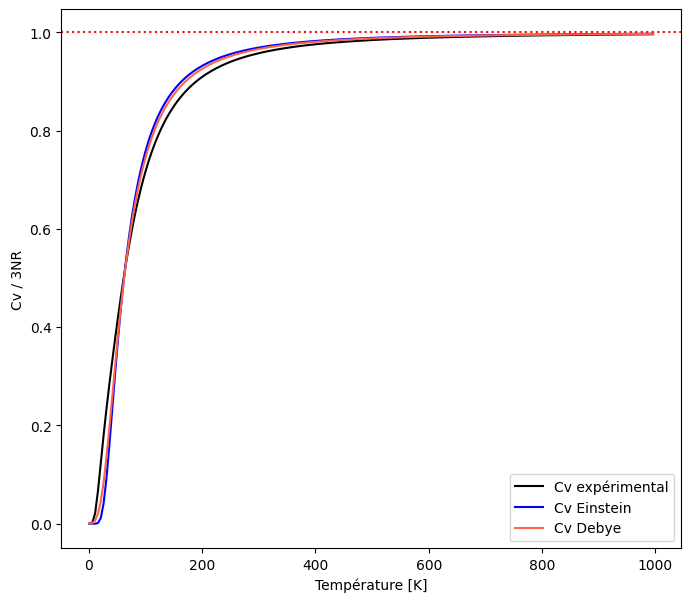

In [61]:
# Calcul des capacités thermiques prédites
cv_e_pred = einstein_cv(T_vals, T_e_opt)
cv_d_pred = np.array([debye_cv(T, T_d_opt) for T in T_vals])

# Tracé des capacités thermiques
plt.figure(figsize=(8, 7))
plt.plot(T_vals, exp_cv, label="Cv expérimental", color='black')
plt.plot(T_vals, cv_e_pred, label="Cv Einstein", color='blue')
plt.plot(T_vals, cv_d_pred, label="Cv Debye", color='tomato')
plt.axhline(y=1, color='red', linestyle='dotted')
plt.xlabel('Température [K]')
plt.ylabel("Cv / 3NR")
plt.legend()
plt.show()

représentation des 3 densités d'états de phonons correspondantes

Dans le cadre de l’étude des propriétés thermodynamiques des solides, la densité d’états des phonons (DOS) joue un rôle central car elle décrit la répartition des modes vibratoires en fonction de la fréquence. Trois approches sont ici considérées. La première est la densité d’états obtenue expérimentalement (ou par calcul ab initio), servant de référence. À celle-ci sont comparés deux modèles théoriques classiques : le modèle d’Einstein et le modèle de Debye. Le modèle d’Einstein suppose que tous les atomes vibrent indépendamment à une fréquence unique, ce qui se traduit par une densité d’états localisée en un point, représentée ici par une raie verticale à la fréquence caractéristique du modèle. En revanche, le modèle de Debye considère un spectre continu de fréquences jusqu’à une fréquence maximale, avec une densité d’états proportionnelle au carré de la fréquence dans le régime acoustique. Les fréquences caractéristiques des deux modèles sont déterminées par ajustement aux données expérimentales à l’aide d’une méthode d’optimisation. Cette comparaison permet d’évaluer la capacité de ces modèles à reproduire le comportement vibratoire réel du matériau, notamment pour le calcul de la chaleur spécifique à basse température.

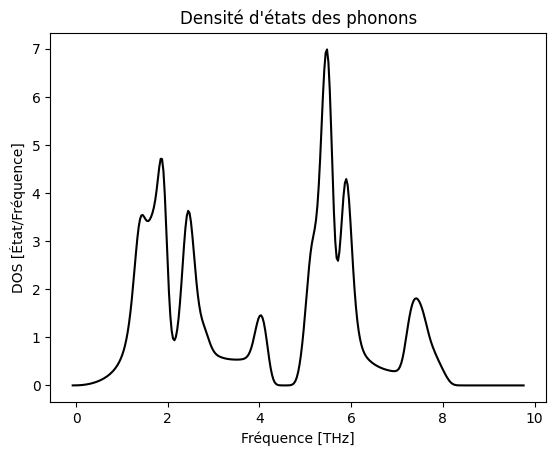

In [62]:

# Tracé de la densité d'états des phonons
frequencies = ph_dos.frequencies
densities = ph_dos.densities

plt.figure()
plt.plot(frequencies, densities, color='black')
plt.xlabel('Fréquence [THz]')
plt.ylabel('DOS [État/Fréquence]')
plt.title("Densité d'états des phonons")
plt.show()

In [63]:
# constantes physiques
k_B = 1.3806485e-23  # J/K
h_bar = 1.055e-34     # J.s
THz_factor = 1e-12

w_E = T_e_opt * k_B * THz_factor / h_bar
w_D = T_d_opt * k_B * THz_factor / h_bar


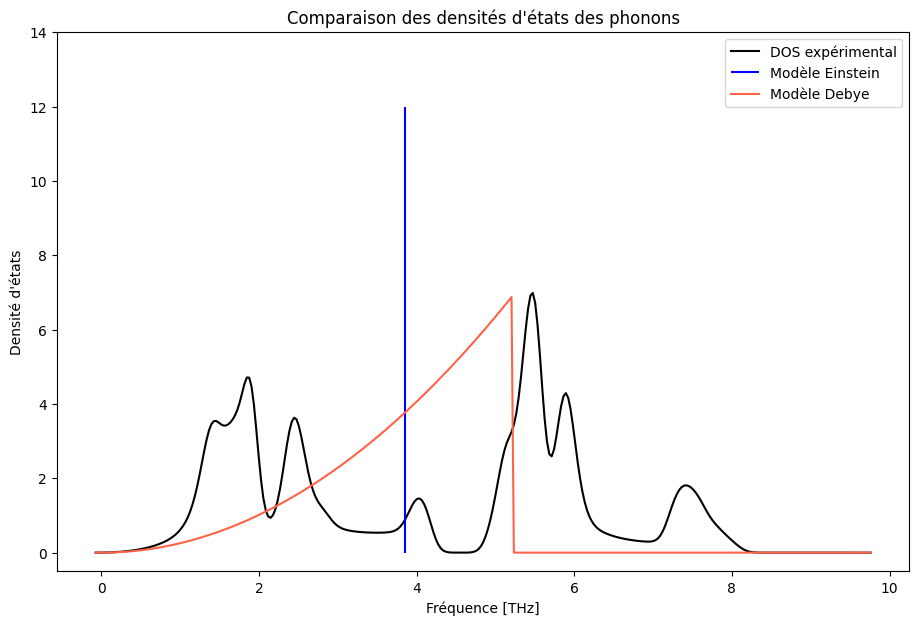

In [64]:
# modèle de Debye pour la densité d'états
debye_dos = np.zeros(len(frequencies))
for i, freq in enumerate(frequencies):
    omega = 2 * np.pi * freq
    if omega < w_D:
        debye_dos[i] = (9 * num_atoms * omega**2 / w_D**3)

# tracé des densités d'états
plt.figure(figsize=(11, 7))
plt.plot(frequencies, densities, color='black', label="DOS expérimental")
plt.vlines(w_E / (2 * np.pi), 0, 3 * num_atoms, color='blue', label="Modèle Einstein")
plt.plot(frequencies, debye_dos * (2 * np.pi), color='tomato', label="Modèle Debye")
plt.title("Comparaison des densités d'états des phonons")
plt.ylabel("Densité d'états")
plt.xlabel("Fréquence [THz]")
plt.ylim(-0.5, 14)
plt.legend()
plt.show()


On observe que ni le modèle d’Einstein ni celui de Debye ne parviennent à reproduire fidèlement la densité d’états des phonons.Bien que ces approches soient fréquemment utilisées pour faciliter les calculs, il est essentiel de garder à l’esprit qu’elles reposent sur des hypothèses simplificatrices.